# Import necassary libraries

In [35]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
from gensim.models.doc2vec import TaggedDocument
from lbl2vec import Lbl2Vec
from sklearn.metrics import f1_score, confusion_matrix, precision_score, balanced_accuracy_score

# Manually define labels and corresponding keywords

In [36]:
labels = pd.DataFrame({'name' : ['factuur','aanmaning'], 'classIndex' : [1,2], 'keywords' : [['rekening','afrekening','factuur'],['aanmaning','herinnering']]})

# Import dataset and view class distribution

<AxesSubplot: >

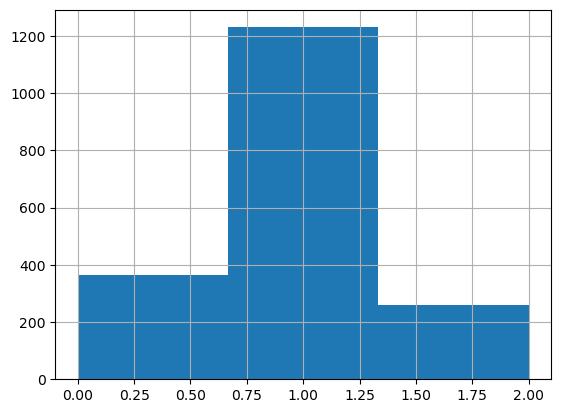

In [37]:
fullDataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
fullDataset['classIndex'].hist(bins=3)

A lot of datapoints with label 'factuur'. Much less with 'aanmaning' en 'ander'

# Split dataset in train/test set and remove 'andere' (other) category

In [38]:
trainSet, testSet = train_test_split(fullDataset, test_size=0.10, stratify=fullDataset['classIndex'], random_state=42)

trainSet['type'] = 'train'
testSet['type'] = 'test'
fullCorpus = pd.concat([trainSet, testSet]).reset_index(drop=True)
fullCorpus = fullCorpus[fullCorpus['classIndex'].isin(list(labels['classIndex']))]
fullCorpus.head()

,Unnamed: 0,names,contents,classIndex,type
0,1714,ee702b77-6016-47b9-8134-31fc5482131a-aanmaningen,woensdag augustus klep onderwerp re service go...,2,train
1,1435,c8c071ae-575c-46f6-aaed-185a8a605cb2-facturen,hallo mogelijk factuur bijlage betalen talent ...,1,train
2,105,0d212b95-a5d9-48cd-b076-6d6799a12475-aanmaningen,nv medium service nv geacht heer mevrouw nazic...,2,train
3,52,05d9df6c-9cd1-43cd-b96d-143da4501340-aanmaningen,partner so kind to date sent september to subj...,2,train
4,548,4ab19178-9090-4d46-8747-e1c5c068cb30-facturen,goed klant gelieve bijlage ons factuur vinden ...,1,train


# Tokenize, tag and prepare documents for training

In [39]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
fullCorpus = fullCorpus.dropna()
fullCorpus['tagged'] = fullCorpus.apply(lambda row: TaggedDocument(tokenize(row['contents']), [str(row.name)]), axis=1)
fullCorpus['documentKey'] = fullCorpus.index.astype(str)
fullCorpus = fullCorpus.merge(labels, left_on='classIndex', right_on='classIndex', how='left')
fullCorpus.head()

,Unnamed: 0,names,contents,classIndex,type,tagged,documentKey,name,keywords
0,1714,ee702b77-6016-47b9-8134-31fc5482131a-aanmaningen,woensdag augustus klep onderwerp re service go...,2,train,"([woensdag, augustus, klep, onderwerp, re, ser...",0,aanmaning,"[aanmaning, herinnering]"
1,1435,c8c071ae-575c-46f6-aaed-185a8a605cb2-facturen,hallo mogelijk factuur bijlage betalen talent ...,1,train,"([hallo, mogelijk, factuur, bijlage, betalen, ...",1,factuur,"[rekening, afrekening, factuur]"
2,105,0d212b95-a5d9-48cd-b076-6d6799a12475-aanmaningen,nv medium service nv geacht heer mevrouw nazic...,2,train,"([nv, medium, service, nv, geacht, heer, mevro...",2,aanmaning,"[aanmaning, herinnering]"
3,52,05d9df6c-9cd1-43cd-b96d-143da4501340-aanmaningen,partner so kind to date sent september to subj...,2,train,"([partner, so, kind, to, date, sent, september...",3,aanmaning,"[aanmaning, herinnering]"
4,548,4ab19178-9090-4d46-8747-e1c5c068cb30-facturen,goed klant gelieve bijlage ons factuur vinden ...,1,train,"([goed, klant, gelieve, bijlage, ons, factuur,...",4,factuur,"[rekening, afrekening, factuur]"


Model will use taggs to vectorise documents

# Define model and start training on training set

In [56]:
Lbl2VecModel = Lbl2Vec(keywords_list=list(labels.keywords), tagged_documents=fullCorpus['tagged'][fullCorpus['type'] == 'train'], label_names=list(labels.name), min_count=2, similarity_threshold=0.4, min_num_docs=15, epochs=25)

Lbl2VecModel.fit()

2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:49,248 - Lbl2Vec - INFO - Train document and word embeddings
2023-02-20 12:12:51,213 - Lbl2Vec - INFO - Train label embeddings
2023-02-20 12:12:51,213 - Lbl2Vec - INFO - Train label embeddings
2023-02-20 12:12:51,213 - Lbl2Vec - INFO - Train label embeddings
2023-02-20 12:12:51,213 - Lbl2Vec - INFO - Train label embeddings
2023-02-20 12:12:51,213 - Lbl2Vec 

### Evaluate performance on training set

In [57]:
model_docs_lbl_similarities = Lbl2VecModel.predict_model_docs()
print(model_docs_lbl_similarities.columns)
evaluationTrain = model_docs_lbl_similarities.merge(fullCorpus[fullCorpus['type'] == 'train'], left_on='doc_key', right_on='documentKey')
yTrueTrain = evaluationTrain['name']
yPredTrain = evaluationTrain['most_similar_label']

print('F1 score:',f1_score(yTrueTrain, yPredTrain, average='micro'))
print('Accuracy score:',balanced_accuracy_score(yTrueTrain,yPredTrain))
#print('Precision score:',precision_score(yTrueTrain,yPredTrain))
print(confusion_matrix(yTrueTrain, yPredTrain))

2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,248 - Lbl2Vec - INFO - Get document embeddings from model
2023-02-20 12:12:51,251 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 12:12:51,251 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 12:12:51,251 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 12:12:51,251 - Lbl2Vec - INFO - Calcul

Index(['doc_key', 'most_similar_label', 'highest_similarity_score', 'factuur',
       'aanmaning'],
      dtype='object')
F1 score: 0.66190833959429
Accuracy score: 0.6558509303128236
[[150  82]
 [368 731]]


### Evaluate performance on test set

In [58]:
new_docs_lbl_similarities = Lbl2VecModel.predict_new_docs(tagged_docs=fullCorpus['tagged'][fullCorpus['type']=='test'])

# merge DataFrames to compare the predicted and true class labels
evaluationTest = new_docs_lbl_similarities.merge(fullCorpus[fullCorpus['type']=='test'], left_on='doc_key', right_on='documentKey')
print(evaluationTest.columns)
yTrueTest = evaluationTest['name']
yPredTest = evaluationTest['most_similar_label']

print('F1 score:',f1_score(yTrueTest, yPredTest, average='micro'))
print('Accuracy score:',balanced_accuracy_score(yTrueTest,yPredTest))
#print('Precision score:',precision_score(yTrueTest,yPredTest))
print(confusion_matrix(yTrueTest, yPredTest))

2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,159 - Lbl2Vec - INFO - Calculate document embeddings
2023-02-20 12:12:52,285 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 12:12:52,285 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 12:12:52,285 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 12:12:52,285 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-02-20 

Index(['doc_key', 'most_similar_label', 'highest_similarity_score', 'factuur',
       'aanmaning', 'Unnamed: 0', 'names', 'contents', 'classIndex', 'type',
       'tagged', 'documentKey', 'name', 'keywords'],
      dtype='object')
F1 score: 0.5945945945945946
Accuracy score: 0.6330390920554855
[[18  8]
 [52 70]]


# Conclusion: 
Model can classify incoming emails with low to ok accuracy and has no dedicated class/keywords for an 'other' class.
Biggest problem is dataset size, too small.

#### Sources:
- https://towardsdatascience.com/unsupervised-text-classification-with-lbl2vec-6c5e040354de